In [5]:
import pandas as pd
# Python modules used for API access...
from chembl_webresource_client.new_client import new_client
from tqdm import tqdm
import pickle
import numpy as np
from functions import PROCESS
import matplotlib.pyplot as plt
import collections

# Initialize PROCESS object
drugs = pd.read_csv('data/primary_data/KIBA_drugs.csv')
obj = PROCESS(drugs)

In [ ]:
"""
Module I: Data retrieval and processing
Use this block to retrieve/process your data by providing a drug file
"""
# Step 1: Extaract terget data for 52k drugs from CHEMBL
main_dict = obj.extractDrugTargets(drugs['drugs'].tolist())
obj.save_obj(main_dict, 'data/main_dict.pkl')

In [ ]:
# Step 2: Extract Drug-Target pairs for Homo-Sapiens with IC50 values
main_dict = obj.load_obj('data/drug_target.pkl')
DTI = obj.getDTI(main_dict)

In [ ]:
# Step 3: Get mapping from CHEMBL to uniprot and save at data/out.txt
obj.chembl2uniprot('data/DTI.csv', 'data/out.txt')

In [7]:
# Step 4: Screen Data based on units, sequence-availiability
DTI = pd.read_csv('data/primary_data/DTI2.csv')
#clean_DTI = obj.screenDTI(DTI, 'data/chembl2uniprot.txt', 'data/clean_DTI.csv')

In [4]:
# Step 5: Transform all activities into one unit (uM)
final_clean_DTI = pd.read_csv('data/clean_DTI.csv')[['target','drug','IC50','unit']]
for i in tqdm(range(len(final_clean_DTI))):
    if final_clean_DTI.at[i,'unit']=='pM':
        final_clean_DTI.at[i,'IC50']=final_clean_DTI.at[i,'IC50']*1000000   # pM to uM
        final_clean_DTI.at[i,'unit']='uM'
    elif final_clean_DTI.at[i,'unit']=='nM':
        final_clean_DTI.at[i,'IC50']=final_clean_DTI.at[i,'IC50']*1000  # nM to uM
        final_clean_DTI.at[i,'unit']='uM'
    elif final_clean_DTI.at[i,'unit']=='mM':
        final_clean_DTI.at[i,'IC50']=final_clean_DTI.at[i,'IC50']/1000  # mM to uM
        final_clean_DTI.at[i,'unit']='uM'
    elif final_clean_DTI.at[i,'unit']=='uM':
        pass
final_clean_DTI.to_csv('data/final_clean_DTI.csv')

100%|██████████| 76872/76872 [00:01<00:00, 45112.92it/s]


In [ ]:
# Step 5: Download fasta files for all proteins
mapping = pd.read_csv('data/chembl2uniprot.txt', header=None, sep='\t')
mapping = mapping[mapping[0].isin(DTI_index['target'].unique())]
for uniprot_ID in tqdm(mapping[1].tolist()):
    wget.download('https://www.uniprot.org/uniprot/'+uniprot_ID+'.fasta', out='data/fasta_968')

In [57]:
collections.Counter(DTI_index.duplicated(['target','drug']))

Counter({False: 61624, True: 15146})

In [67]:
collections.Counter(DTI_index['activity'])

Counter({'intermediate': 25589, 'inactive': 28748, 'active': 7287})

In [69]:
# Step 6
# Import and process level 2 data
drug_smiles = pd.read_csv('data/primary_data/smiles.csv')[['drug','smile']]  # Drug index dataframe
drug_smiles['seq_char_count'] = drug_smiles['smile'].apply(lambda x: len(str(x)))   # Add column with character count
drug_smiles = drug_smiles[drug_smiles['smile'].notnull()]   # Remove drugs with no smile strings

DTI_index = pd.read_csv('data/primary_data/final_clean_DTI.csv')[['target','drug','IC50','unit']]
DTI_index = DTI_index[DTI_index['drug'].isin(drug_smiles['drug'].tolist())]     # Exclude drugs for which smiles are not available
DTI_index = DTI_index[~DTI_index.duplicated(['target','drug'])]     # Remove duplicate datapoints
DTI_index = DTI_index.reset_index(drop=True)

mapping = pd.read_csv('data/primary_data/chembl2uniprot.txt', header=None, sep='\t')
mapping = mapping[mapping[0].isin(DTI_index['target'].unique())]    # Select targets that are present in data (DTI_index)
targets = os.listdir('data/fasta_968')  # List all target fasta files

# Categorize drug-target pairs by IC50 values (Make labels)
act = []
bct = []
for i in tqdm(range(DTI_index.shape[0])):
    if DTI_index['IC50'][i]<=0.1:
        act.append('active')
    elif DTI_index['IC50'][i]>0.1 and DTI_index['IC50'][i]<=30:
        act.append('intermediate')
    elif DTI_index['IC50'][i]>30:
        act.append('inactive')
    bct.append(mapping[mapping[0]==DTI_index['target'][i]][1].values[0])
    
DTI_index['activity'] = act
DTI_index['target_uniprot'] = bct

# Step 7
# Fetch fasta sequences form files and create target index dataframe
def fetchFasta(targets):
    target_seq = pd.DataFrame(columns=['target_uniprot','target_chembl','seq'])
    for fasta in tqdm(targets):
        if fasta.split('.')[0] in mapping[1].tolist():
            f = open('data/fasta_968/'+fasta,'r')
            lines = "".join(line.strip() for line in f.readlines()[1:])
            dict = {'target_uniprot':fasta.split('.')[0],'target_chembl':mapping[(mapping[1]==fasta.split('.')[0])][0].values[0], 'seq':lines}
            target_seq = target_seq.append(dict, True)
            f.close()
    return target_seq

target_seq = fetchFasta(targets)
# Length of sequence in train data.
#target_seq['seq_char_count'] = target_seq['seq'].apply(lambda : len(x))

DTI_index.to_csv('data/DTI_index.csv')
target_seq.to_csv('data/target_seq.csv')
drug_smiles.to_csv('data/drug_smiles.csv')

100%|██████████| 968/968 [00:03<00:00, 250.94it/s]


In [ ]:
"""
Module II: Feature retrieval and processing
Use this block to retrieve/process your data by providing a drug file
"""
# Extract drug descriptors
attribs = [
      'MaxAbsPartialCharge', 'MinPartialCharge', 'MinAbsPartialCharge', 'HeavyAtomMolWt', 'MaxAbsEStateIndex', 'NumRadicalElectrons',
      'NumValenceElectrons', 'MinAbsEStateIndex', 'MaxEStateIndex', 'MaxPartialCharge', 'MinEStateIndex', 'ExactMolWt', 'MolWt', 'BalabanJ',
      'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v',
      'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 
      'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1',
      'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12',      'SlogP_VSA2','SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'EState_VSA1', 'EState_VSA10', 
      'EState_VSA11', 'EState_VSA2',      'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9',
      'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8',
      'VSA_EState9', 'FractionCSP3', 'HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles',
      'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms',
      'NumRotatableBonds', 'NumSaturatedCarbocycles','NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolLogP', 'MolMR'
    ]

fset_mol=pd.DataFrame()
for chembl_id in tqdm(drugs['drugs']):
    descriptors, status = obj.mol2des(chembl_id, attribs)
    if status:
        fset_mol = fset_mol.append(descriptors)
fset_mol.to_csv('fset_drugs.csv')

# Extract protein descriptors
des = obj.extractProteinDes('AAC', 'data/chembl2uniprot.txt')

In [ ]:
# Extract smile strings for every drug
smile = []
for drug in tqdm(final_clean_DTI['drug'].unique()):
    smile.append(new_client.activity.filter(molecule_chembl_id=drug).only(['canonical_smiles'])[0]['canonical_smiles'])
smile_df = pd.DataFrame(final_DTI['drug'].unique(), columns=['drug'])
smile_df['smile'] = smile
smile_df.to_csv('data/smiles.csv')

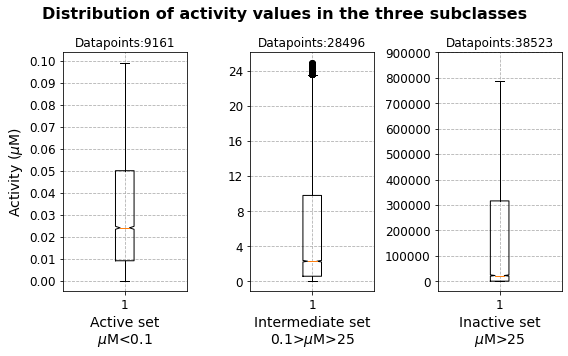